<a href="https://colab.research.google.com/drive/1PzXWr_R1KsinDcoGdFwVjjYIYgnvP1Ck?authuser=1#scrollTo=view-in-github" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LOADING THE LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import catboost as catt
from tqdm import tqdm_notebook
import os, sys, gc, warnings, random
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

from sklearn.preprocessing import FunctionTransformer, SplineTransformer
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

## LOADING THE DATA

In [2]:
path=r""
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73,28.77,2019,1,0.000167,0.713172,0.000102,0.223929,24.939440,...,5566.222019,54826.032616,4606.209995,19.115282,0.353778,24.951948,49.053953,-89.638032,17.988874,86.051700
1,ID_-23.73_28.77_2019_2,-23.73,28.77,2019,2,-0.000155,0.812910,-0.000137,0.080281,16.624162,...,3711.511365,68491.753342,3034.461661,12.218664,0.244987,4.708856,42.586683,-89.904314,22.773246,88.875670
2,ID_-23.73_28.77_2019_3,-23.73,28.77,2019,3,-0.000065,0.860306,-0.000062,0.161050,-13.237244,...,2136.385189,78967.739548,1433.482587,6.062737,0.245102,76.060628,34.737544,-83.595254,17.437300,91.723114
3,ID_-23.73_28.77_2019_4,-23.73,28.77,2019,4,0.000152,0.422284,0.000087,0.046504,-13.534653,...,3841.853018,64592.806769,2878.512917,6.388233,0.210904,75.912368,60.294490,-71.896728,11.977818,92.883870
4,ID_-23.73_28.77_2019_5,-23.73,28.77,2019,5,0.000024,1.004578,0.000028,0.214246,-13.475718,...,1295.688171,86804.025391,1094.665344,9.206252,0.261103,-13.346079,50.194493,-77.462082,24.374270,94.878330


## REMOVING NANS WITH MISSING VALUES GREATER THAN THE THRESH

In [3]:
def remove_nans(train,thresh) :
    def nans_rate(train,col) :
        return train[col].isna().sum() / train.shape[0]

    for col in train.columns :
        if nans_rate(train,col) >= thresh :
              train.drop(col,axis=1,inplace=True)
    return train
train = remove_nans(train,thresh=0.8)
test = test[train.columns[:-1]]
train.shape, test.shape

((74005, 69), (28085, 68))

## FEATURE ENGINEERING

In [4]:
def prepare(train , test) :
    data = pd.concat([train,test])

    # Create location feature
    data.latitude, data.longitude = round(data.latitude, 2), round(data.longitude, 2)
    data['location'] = [str(x) + '_' + str(y) for x, y in zip(data.latitude, data.longitude)]
    data = data.sort_values(by = ['location', 'year', 'week_no'])

    #seperate columns not needed for feature engineering from those required
    angle_cols = [col for col in data.columns if 'angle' in col or 'altitude' in col or 'depth' in col or \
                  'height' in col]
    transform_cols = [col for col in data.columns if col not in angle_cols +['ID_LAT_LON_YEAR_WEEK','year_week',\
                    'longitude','latitude','emission','year_month','month','latitude','longitude' 'location',\
                    'location','bin','year','week_no',]]

    # Create cyclical features -sine and cosine
    def sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period *2 * np.pi))

    def cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    # Create spline features
    def periodic_spline_transformer(period, n_splines=None, degree=3):
        if n_splines is None:
            n_splines = period
        n_knots = n_splines + 1 # periodoc and include bias = True
        return SplineTransformer(degree=degree,
                                n_knots=n_knots,
                                knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
                                extrapolation="periodic",
                                include_bias=True)

    #Create Month Feature
    def getMonth(year: int, week: int) -> int:
        return datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").month
    data['month'] = data.apply(lambda x: getMonth(x['year'], x['week_no']), axis=1)

    # Extract trigonometric features
    data["month_sin"] = sin_transformer(12).fit_transform(data["month"])
    data["month_cos"] = cos_transformer(12).fit_transform(data["month"])

    # Extract periodic spline-based features
    spline_cols_month = [f"cyclic_month_spline_{i}" for i in range(1, 7)]
    data[spline_cols_month] = periodic_spline_transformer(25, n_splines=6).\
    fit_transform(np.array(data.month).reshape(-1,1))

    # extract rolling features
    for col in transform_cols:
        for i in range(25,125,25):
            data[f"{col}_rolling_mean_{i}"] = data[col].rolling(window=i).mean()
            data[f"{col}_rolling_mean_{i}"] = data[col].rolling(window=i).min()
            data[f"{col}_rolling_mean_{i}"] = data[col].rolling(window=i).max()

        data[f"{col}__location_mean"] = data.groupby(['location'])[col].transform('mean')
        data[f"{col}__location_min"] = data.groupby(['location'])[col].transform('min')
        data[f"{col}__location_max"] = data.groupby(['location'])[col].transform('max')

    #Final preparation-drop cols not needed
    data = data.drop(columns = angle_cols + ['longitude','latitude'])

    #Final preparation-split back to the train and test dataset that was there initially
    train = data[data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]
    test = data[~data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]
    return train , test

#Call the function
train,test =prepare(train,test)

#sort the train and test based on location year and week number since this is time series!
train = train.sort_values(by = ['location','year','week_no'])
test = test.sort_values(by = ['location','year','week_no'])
train.head()

,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_cloud_base_pressure__location_mean,Cloud_cloud_base_pressure__location_min,Cloud_cloud_base_pressure__location_max,Cloud_surface_albedo_rolling_mean_25,Cloud_surface_albedo_rolling_mean_50,Cloud_surface_albedo_rolling_mean_75,Cloud_surface_albedo_rolling_mean_100,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max
0,ID_-23.73_28.77_2019_1,2019,1,0.000167,0.713172,0.000102,0.223929,0.000033,0.023408,2829.881106,...,74799.35037,29683.367704,89939.33421,NaN,NaN,NaN,NaN,0.214901,0.120367,0.462689
1,ID_-23.73_28.77_2019_2,2019,2,-0.000155,0.812910,-0.000137,0.080281,-0.000067,0.024189,2136.614929,...,74799.35037,29683.367704,89939.33421,NaN,NaN,NaN,NaN,0.214901,0.120367,0.462689
2,ID_-23.73_28.77_2019_3,2019,3,-0.000065,0.860306,-0.000062,0.161050,-0.000031,0.023697,1907.515503,...,74799.35037,29683.367704,89939.33421,NaN,NaN,NaN,NaN,0.214901,0.120367,0.462689
3,ID_-23.73_28.77_2019_4,2019,4,0.000152,0.422284,0.000087,0.046504,0.000031,0.022360,2122.067948,...,74799.35037,29683.367704,89939.33421,NaN,NaN,NaN,NaN,0.214901,0.120367,0.462689
4,ID_-23.73_28.77_2019_5,2019,5,0.000024,1.004578,0.000028,0.214246,0.000005,0.023042,1750.011133,...,74799.35037,29683.367704,89939.33421,NaN,NaN,NaN,NaN,0.214901,0.120367,0.462689


## MODELLING -LGB

In [5]:
X = train.drop(['ID_LAT_LON_YEAR_WEEK','emission','location'], axis = 1).fillna(0)
y = train.emission
fold_pred=[]
oof_pred = []

params1 = {'learning_rate': 0.15592472218053005, 'subsample': 0.9072713541530352, \
           'colsample_bytree': 0.5062834624362592, 'max_depth': 12, 'objective':'rmse'}

# split was done by month also not only location. so we stratify based on month
fold= StratifiedKFold(n_splits=12)
i=1
for train_index, test_index in fold.split(X,X['month']):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = lgb.LGBMRegressor(**params1, n_estimators = 3050)

    model.fit(X_train,y_train,eval_set=[(X_test ,y_test)], early_stopping_rounds=120, verbose = 250)#erly100

    preds= model.predict(X_test,num_iteration=model.best_iteration_ )
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds), squared=False))
    p2 = model.predict(test[X.columns],num_iteration=model.best_iteration_)
    fold_pred.append(np.expm1(p2))

preds = np.mean(fold_pred,axis=0)
sub = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test['ID_LAT_LON_YEAR_WEEK'],
    'target': preds})

sub.to_csv(path + 'lgb.csv', index = False)
print(np.mean(oof_pred))

err:  2216.5519648655
err:  1797.0949786272542
err:  1567.4325634580753
err:  175445.5027277865
[250]	valid_0's rmse: 22843.6
[500]	valid_0's rmse: 22843.6
err:  11133.237973795449
err:  2525.6825244165416
err:  1552.8956623279573
err:  7556.954306431285
[250]	valid_0's rmse: 6216.53
[500]	valid_0's rmse: 6216.53
err:  3775.907201049369
[250]	valid_0's rmse: 17627
err:  11345.947526958977
[250]	valid_0's rmse: 2385.35
err:  1826.725958003762
[250]	valid_0's rmse: 9021.54
err:  8765.479442832773
19125.78440254612


Text(0.5, 1.0, 'Lightgbm features importance (top 20):')

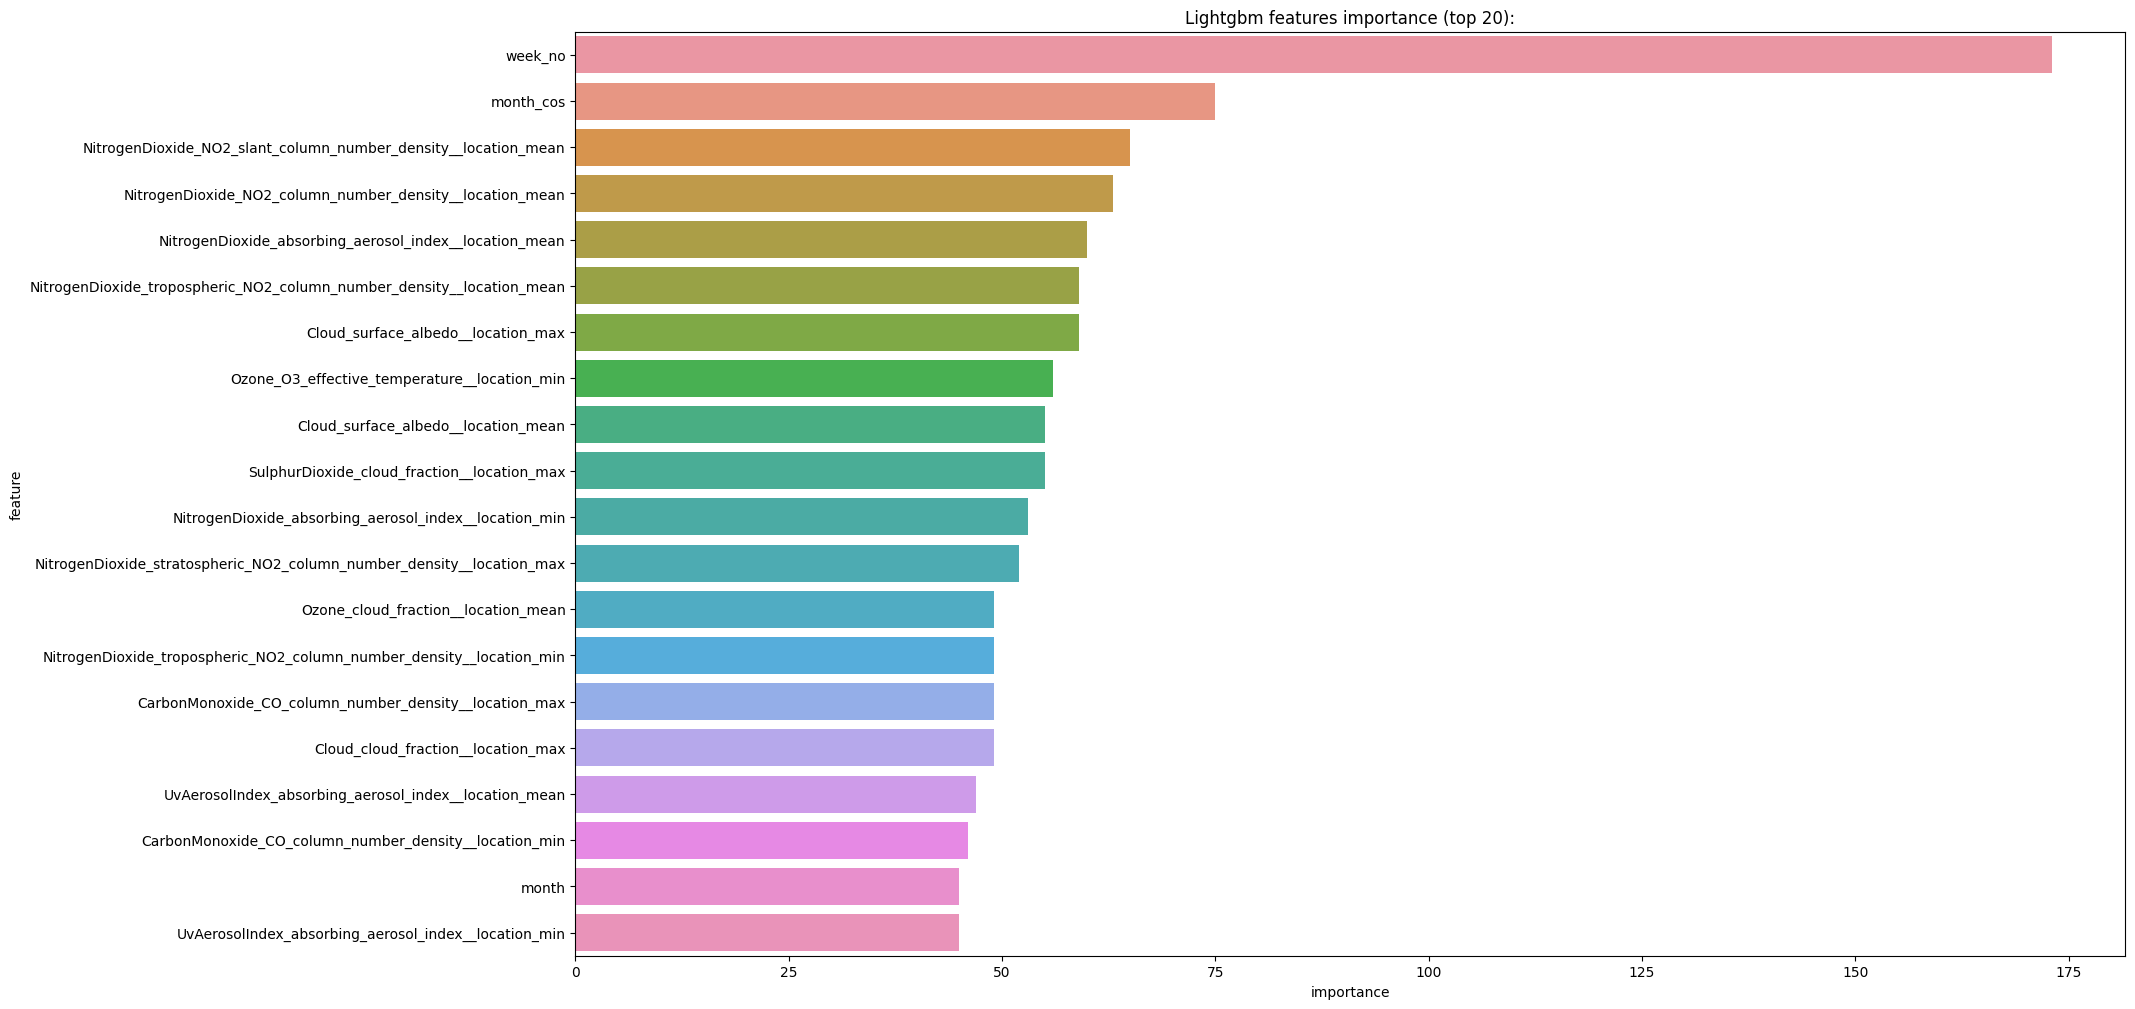

In [6]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'],\
                                                                                ascending = False).head(20))
plt.title('Lightgbm features importance (top 20):')

## MODELLING - CatBoost


In [7]:
cb_model = catt.CatBoostRegressor(random_state=7)
cb_model.fit(X, y, verbose=2000)

preds = (cb_model.predict(test[X.columns]))

prediction = preds
prediction[prediction < 0] = 0

submission = pd.DataFrame()
submission['ID_LAT_LON_YEAR_WEEK'] = test['ID_LAT_LON_YEAR_WEEK']
submission['target'] = prediction
submission.to_csv(path + "cat.csv", index=False)
submission.head()

Learning rate set to 0.080821
0:	learn: 48593.5841472	total: 220ms	remaining: 3m 39s
999:	learn: 555.2129179	total: 1m 24s	remaining: 0us


,ID_LAT_LON_YEAR_WEEK,target
0,ID_-23.53_27.47_2019_1,0.000000
1,ID_-23.53_27.47_2019_2,0.000000
2,ID_-23.53_27.47_2019_3,86.184104
3,ID_-23.53_27.47_2019_4,0.000000
4,ID_-23.53_27.47_2019_5,0.000000


### AVERAGE ENSEMBLE

In [11]:
cat = pd.read_csv(path + 'cat.csv')
lgb = pd.read_csv(path + 'lgb.csv')
ensemble = lgb.copy()
ensemble['target'] = lgb['target']*0.5 + cat['target']*0.5
ensemble.to_csv(f"./ensemble.csv",index=False)